**Классификация мест залежей нефти и газа**

*Импортируем необходимые библиотеки и загрузим данные*

In [467]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

train = pd.read_csv("train_oil.csv")
test = pd.read_csv("oil_test.csv")

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")


Train dataset shape: (309, 20)
Test dataset shape: (133, 19)


*Посмотрим пропуски и удалим их*

In [468]:
missing_percent = train.isnull().mean() * 100
print(missing_percent[missing_percent > 0])

train = train.dropna()
print(train.isnull().sum().sum())

Country        8.737864
Region        12.297735
Basin name    12.297735
Latitude       8.737864
Longitude      9.708738
dtype: float64
0


*Посмотрим распределение целевой метки и переведем целевую переменную в числовой формат*

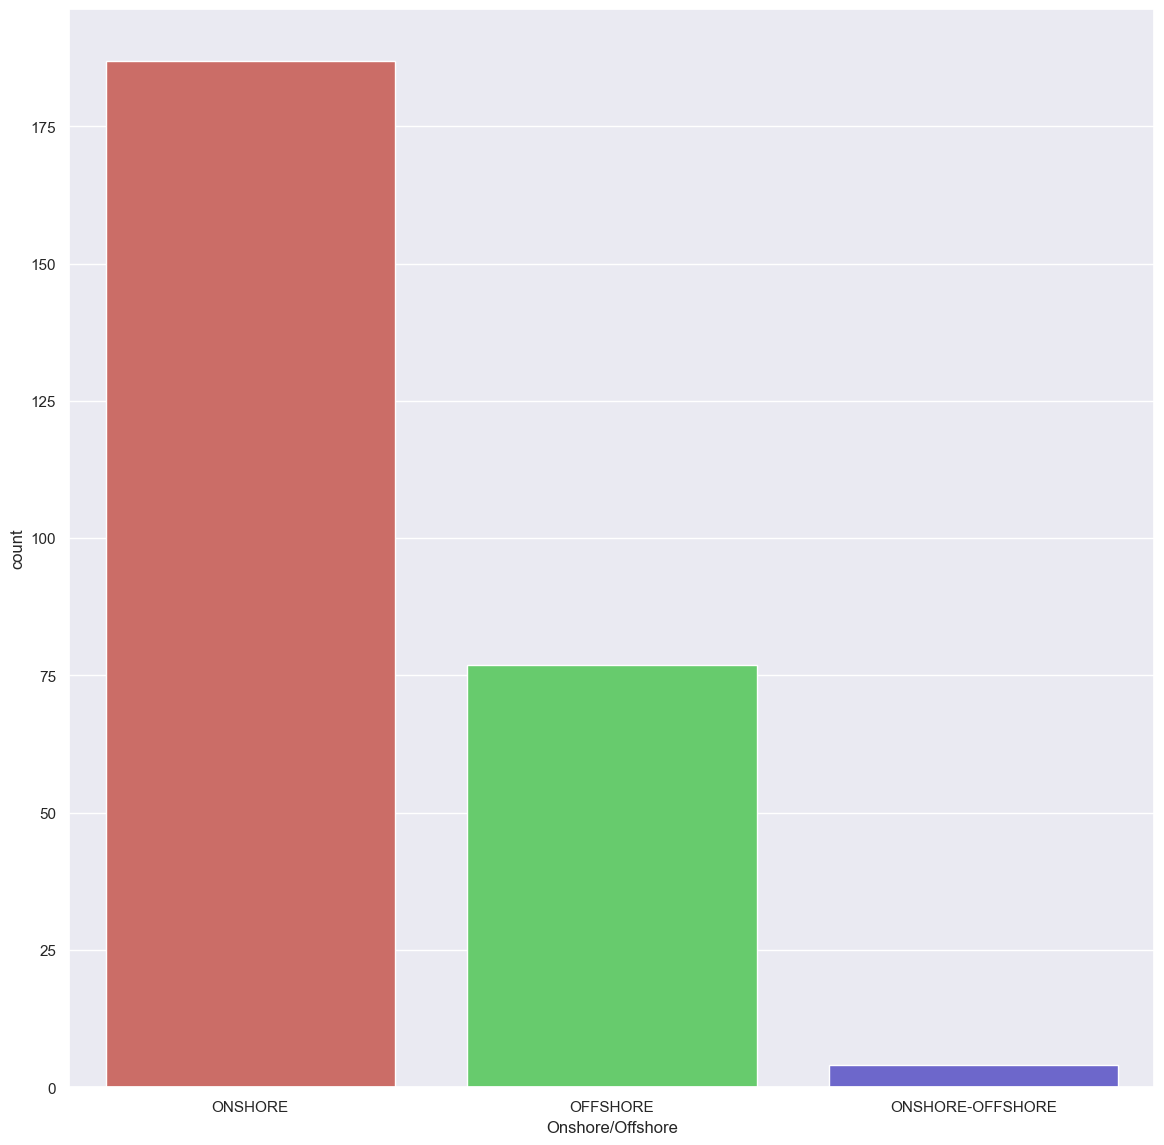

Onshore/Offshore
ONSHORE             187
OFFSHORE             77
ONSHORE-OFFSHORE      4
Name: count, dtype: int64


In [469]:
sns.countplot(x='Onshore/Offshore', data=train, palette='hls')
plt.show()

print(train['Onshore/Offshore'].value_counts())

target_map = {'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2}
train['Onshore/Offshore'] = train['Onshore/Offshore'].map(target_map)


*Переведем в числовой формат все нечисловые параметры*

In [470]:
categorical_cols = [
    'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 
    'Tectonic regime', 'Structural setting', 'Field name', 'Reservoir unit', 
    'Country', 'Region', 'Basin name', 'Operator company'
]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])


*Матрица корреляции*

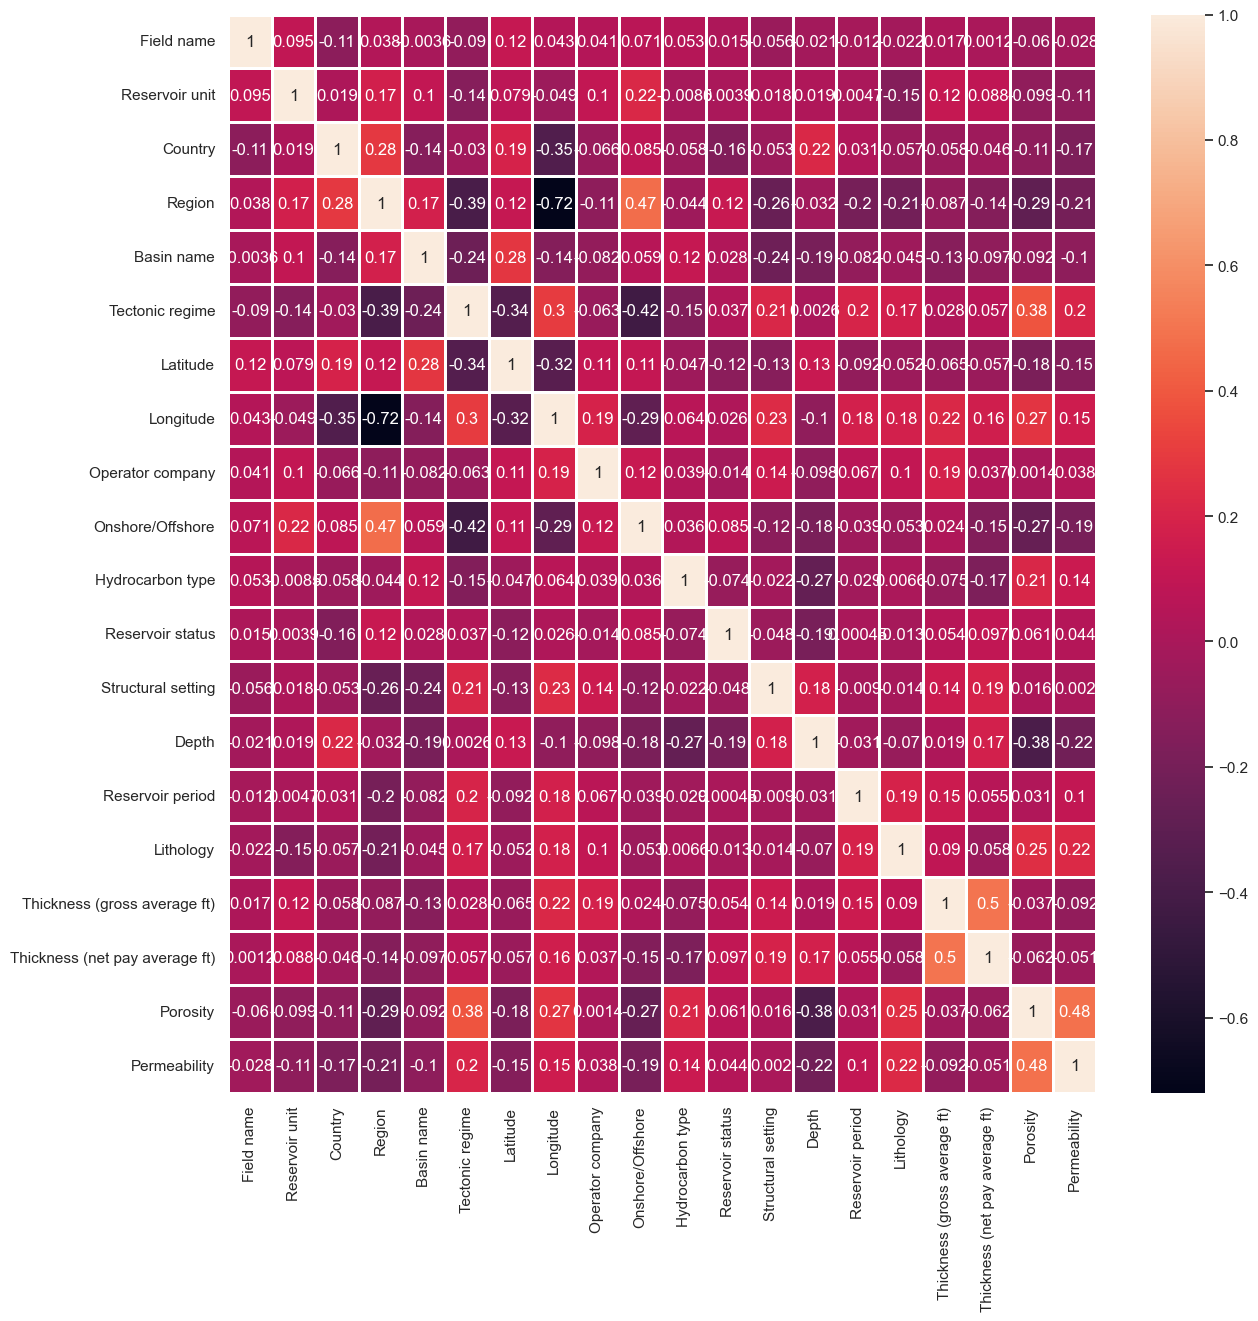

In [471]:
plt.figure(figsize=(14,14))
sns.heatmap(train.corr(numeric_only=True), annot=True, linecolor='white', linewidths=1)
plt.show()


In [472]:
corr_with_target = train.corr(numeric_only=True)['Onshore/Offshore'].sort_values(ascending=False)
print(corr_with_target)


Onshore/Offshore                  1.000000
Region                            0.473544
Reservoir unit                    0.218507
Operator company                  0.122282
Latitude                          0.111805
Reservoir status                  0.084878
Country                           0.084590
Field name                        0.070518
Basin name                        0.058898
Hydrocarbon type                  0.035633
Thickness (gross average ft)      0.024281
Reservoir period                 -0.038978
Lithology                        -0.053494
Structural setting               -0.115848
Thickness (net pay average ft)   -0.151302
Depth                            -0.184756
Permeability                     -0.190866
Porosity                         -0.268944
Longitude                        -0.293879
Tectonic regime                  -0.424822
Name: Onshore/Offshore, dtype: float64


*Определеим целевую переменную*

In [473]:
X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

*Разбиение данных*

In [474]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_valid.shape)
print(y_train.value_counts(), y_valid.value_counts())


(241, 19) (27, 19)
Onshore/Offshore
1    168
0     69
2      4
Name: count, dtype: int64 Onshore/Offshore
1    19
0     8
Name: count, dtype: int64


*Применим метод SMOTE для устранения дисбаланса в данных*

In [475]:
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f'Size after SMOTE: {X_train_res.shape}')
print(y_train_res.value_counts())


Size after SMOTE: (504, 19)
Onshore/Offshore
0    168
1    168
2    168
Name: count, dtype: int64


*Обучим для разнообразия и выбора три модели (выбраны Decision Tree, KNN, Random Forest)*

In [476]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')

Decision Tree Accuracy: 0.7407
KNN Accuracy: 0.4815
Random Forest Accuracy: 0.9259


*Лучшая модель Random Forest - выберем ее для предсказания и загрузим решение в csv*

In [478]:
rf = models["Random Forest"]  

test_preds = rf.predict(test)
submission = pd.DataFrame({'Onshore/Offshore': test_preds})
submission.index.name = 'index'
submission.to_csv('submission.csv')

**Kaggle**

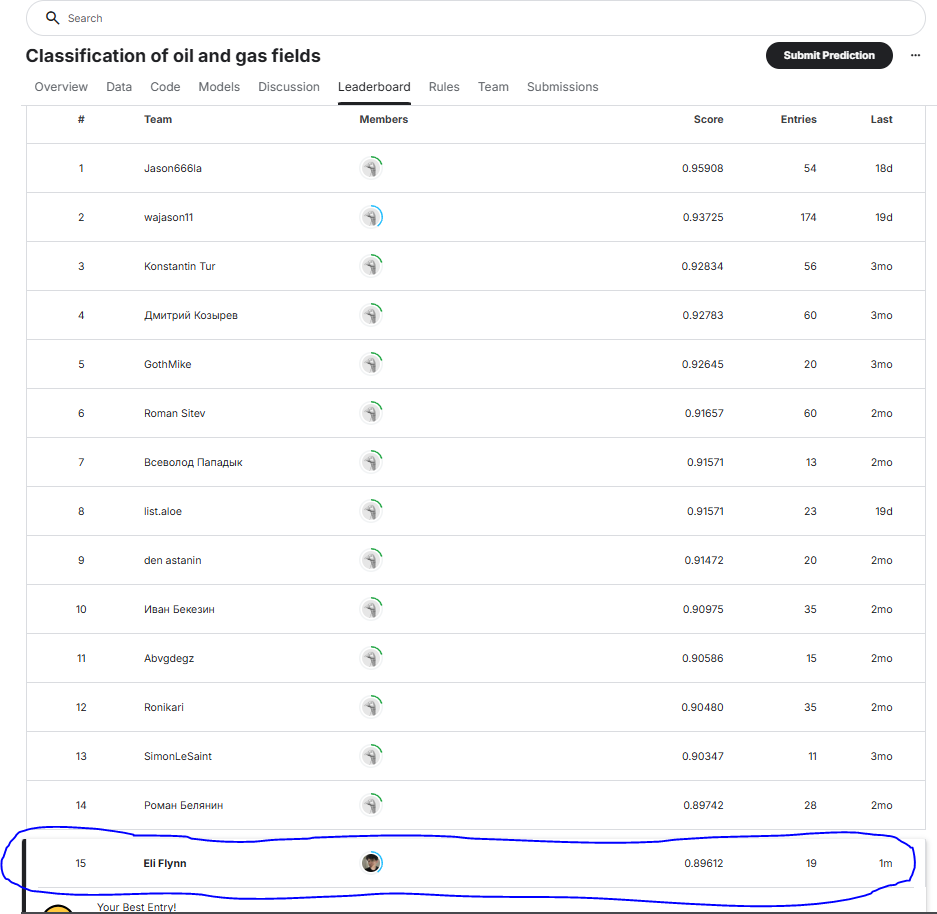